In [191]:
import math 
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
f(3.0)

20.0

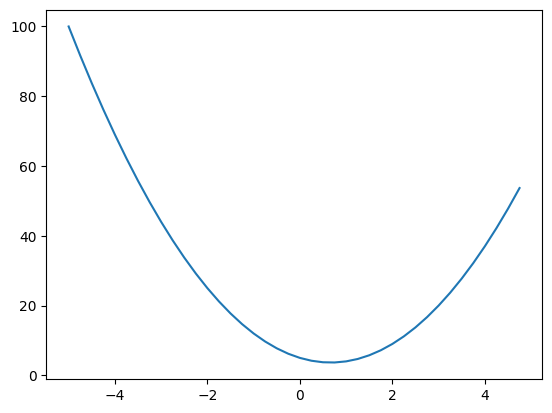

In [16]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [20]:
# from the formal definition of the derivate we are going to set h, remember that h->0 in the derivate expression
h = 0.0001  # as h closes to 0 we need to set a small value of h to aproximate to the real derivate
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

In [24]:
# let's get more complex on derivates, we are going to use the concept of derivate and partition it so
# we can use partial derivates

h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c # our function f(x)
c += h # increment by h the variable we want to derivate
d2 = a*b + c # now that we have bumped up a variable by h this is f(x) + h

print('slope', (d2 - d1) / h) # we print the slope or derivate (f(x-h) - f(x))/h 

slope 0.9999999999976694


In [188]:
# class Value

# data: numerical value of this class
# _children are the items that conforms a Value object over an operation like add or mul
# _op is the operation performed over a Value object
# label is the label of the value
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._backward = lambda: None
    self._op = _op
    self.label = label

  # representing this class in string form 
  def __repr__(self):
    return f"Value(data={self.data})"
  
  # adding the addition capability between data of the Value object and other value
  # if other is not an instance of this class wrap it with this class
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  # adding the multiplication capability between data of the Value object and other value
  # if other is not an instance of this class wrap it with this class
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  # function for applying the power against other value, also spreading the gradient
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  # because __mul__ is not enough to handle the properties of multiplication, we need this
  # function to apply properly the properties
  def __rmul__(self, other): # other * self
    return self * other

  # function that represents the generalized way of division, x * y^-1
  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  # implementing the tanh activation function and spreading the gradient
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  # function for euler value (e) also it spreads the local derivate (gradient)
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  # function to spread the gradient based on a topolical graph, apply this to the backward 
  # dynamically from the Value class
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [123]:
# these functions are for drawing the diagrams
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = left to right
    nodes, edges =  trace(root)
    for n in nodes:
        uid=str(id(n))
        # for any value in the graph create a rectanfular('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

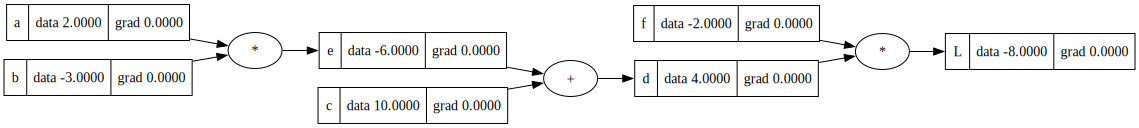

In [137]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L
draw_dot(L)

In [84]:
# setting the gradients for each node and calculating manually the backpropagation

# these values are set based on calculations made on paper
L.grad = 1.0  # dL/dL
d.grad = -2.0 # dL/dd = f
f.grad= 4.0 # dL/df = d

# now that we know the grad of L, d and f. we want to know the grad of e and c, this would be dd/de and dd/dc. but how much
# do we know in terms of sensitivity how e and c affects L, we need the chain rule for this

# if we want to know how L is affected by c
# WANT: dL/dc = (dL/dd) * (dd/dc)

# dd/dc = 1 and dL/dd = f so following the chain rule this is dL/dc = f * 1 = -2.0 and by symmetry dL/de = -2.0
c.grad = -2.0
e.grad = -2.0

# now we are going all the way to the left of the graph and find the gradient of a, we now by the chain rule that
# dL/da = (dL/de) * (de/da) we already know that dL/de = -2.0 so now we have dL=(-2.0) * (de/da)

a.grad = 6.0
b.grad = 4.0

In [154]:
# now we are going to do this with a neuron,, following the theory of the neuron

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neeuron
b = Value(6.8813735870195432, label="b")

# all together for the neuron --> x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

# we need to pass this thru an activation function, preferably tanh
o = n.tanh(); o.label='o'
o.backward()


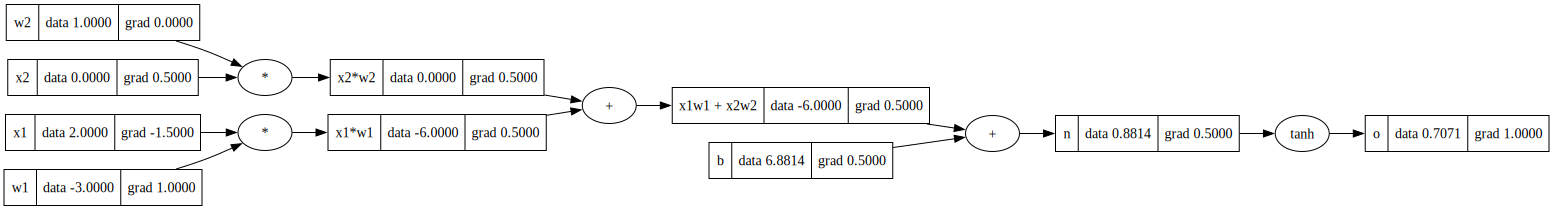

In [155]:
# plot the result of the neuron
draw_dot(o)

In [100]:
# now this is only one neuron, we need to backpropagation on this neuron going from o to the initial weights
# first, we need to know the derivate of o respect to n (do/dn) we know that n is doing an operation with tanh
# and the derivate of tanh is 1-tanh(n)**2, tanh is o so we then we have 1-o.data**2 that's equal to 0.5

o.grad = 1.0
n.grad = 0.5

## keeping  in mind that the plus (+) is just a propagator of the gradient, we can say that the gradient from 
# n is the same for x1w1 + x2w2 and b

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

# up to the last derivates we apply the chain rule
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [115]:
# using the backward function we need to set as a base the o.grad = 1.0 because it is first initialized as 0
o.grad = 1.0
o._backward()

n._backward()

b._backward()
x1w1x2w2._backward()

x2w2._backward()
x1w1._backward()

In [117]:
# in order to not do this manually, we are going to create a topological graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

# build the topological graph
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.7),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

In [134]:
# now we can use backwrd for the whole graph just calling the Value.backward() function
o.backward()

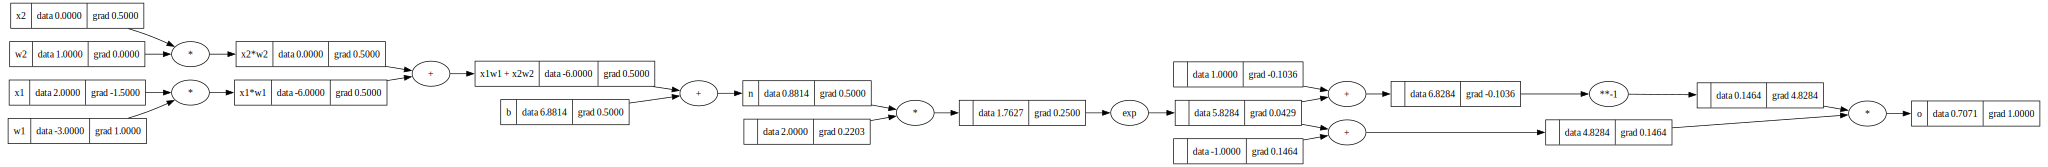

In [189]:
# we are going to do an exercise of splitting the tanh function with the new ops methods from the Value claass

# we implement the same neuron but now following the raw formula for the tanh function 

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neeuron
b = Value(6.8813735870195432, label="b")

# all together for the neuron --> x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

# implementing tanh manually
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = "o"
o.backward()
draw_dot(o)


In [257]:
# now we can apply and create a neural network

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    # we can grab all the parameters of the neuron
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [296]:
# testing the nerual net - creating it
x = [2.0, 3.0, -1.0] # inputs
n = MLP(3, [4, 4, 1]) # MLP(input_layer, [hidden_layers, output_layer])
n(x) # this is the prediction over x 

Value(data=-0.3651376678718107)

In [297]:
# let's create a tiny dataset and find the loss of the neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [292]:
# now let's calculate the loss of the network by the loss metric (y - ypred)**2 
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.7892907946291965)

In [280]:
# we can do backpropagation from the loss value to the first nodes of the entire graph
loss.backward()

In [266]:
# we can check the gradient of one specific weight in a neuron inside a layer
n.layers[0].neurons[0].w[0].grad

0.052190172949920066

In [269]:
n.layers[0].neurons[0].w[0].data

-0.9932012558386971

In [265]:
# Now we want to take all the parameters and start changing the weights so we can minify the loss value
len(n.parameters())

41

In [281]:
# we iterate over each parameter and take the data of its node and compute the value with the gradient.
# now, we need to move the gradient a step further to actualy change the node's data value, we do that
# by interpreting the gradient as a vector that points in the opposite direction of the loss, this means
# that if the data of the node increases the loss is going to decrease ( invertion proportion ) this is because
# the derivate of that grad is negative so we put a negative sign in the step further (-0.01) to increase the data
# of the node and then decrease the loss value
for p in n.parameters():
    p.data += -0.01 * p.grad

In [282]:
# now the value of the node we saw earlier should be greater than before
n.layers[0].neurons[0].w[0].data

-0.997700371750359

In [298]:
# now we can take every step together and put a number of steps into the iteration of each pass

for k in range(20):
    # forward pass - calculate the loss, gradients still with 0.0 value on each node
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

    # we reset the grad to 0 so we can clean the previous grad and don't accumulate the gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass (backpropagation) - calculate gradient(partial derivates) for each node with respect of the loss
    loss.backward()

    # based on the grads for each node and the random weights and biases of each, update the nodes data based on the parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad # -0.05 is the step further or learning rate as they call it
    
    # print results
    print(k, loss.data)


0 5.506948370892521
1 1.9633640452659504
2 1.0642241093929963
3 0.7040269920555217
4 0.51090765051426
5 0.39428235162919684
6 0.317796138074237
7 0.26444730013483597
8 0.22543626297077096
9 0.1958328260625215
10 0.17269216390169767
11 0.15416075926346146
12 0.13902026100723008
13 0.12644016413468864
14 0.11583661314078025
15 0.10678815719107149
16 0.09898353793322948
17 0.092188243235269
18 0.08622245320273726
19 0.08094612227828987


In [299]:
# check results
ypred

[Value(data=0.8953883448238653),
 Value(data=-0.9028551185991802),
 Value(data=-0.8153437047110564),
 Value(data=0.8373118058758334)]